<a href="https://colab.research.google.com/github/sergiorkd/Studying_PINNs/blob/main/PINN_underdamped_oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Exact Solution


In [ ]:
from IPython.display import Image
display(Image(filename='/content/problem boundaries.png', width=300))

initial conditions  
m=1  
x0=1  
v0=0

In [ ]:
def exact_solution(d, w0, t):
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    #print('w', w)
    #print('phi', phi)
    #print('A', A)
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    #print('cos', cos)
    #print('exp', exp)
    x = exp*2*A*cos
    return x

In [ ]:
m=1
d=2
w0=20
mu=2*d*m
k=(w0*m)**2
t_test = torch.linspace(0,3,300).view(-1,1)
x_exact = exact_solution(d, w0, t_test)

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(t_test[:,0], x_exact[:,0])
plt.xlabel('time')
plt.ylabel('x')

## Building the network pinn

In [ ]:
#defining the feed forward NN class
class FFN(nn.Module):
    #creating the initialization function of the class
    def __init__(self, N_input, N_output, N_hidden):
        super().__init__()
        #activation function hyperbolic tangent
        activation = nn.Tanh
        self.ffni = nn.Sequential(nn.Linear(N_input, N_hidden), activation())
        self.ffnh = nn.Sequential(nn.Linear(N_hidden, N_hidden), activation())
        #no activation function for the output layer
        self.ffne = nn.Sequential(nn.Linear(N_hidden, N_output))

    def forward(self, x):
        x = self.ffni(x)
        #two hidden layers
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

In [ ]:
torch.manual_seed(123)
#settinf the NN with 1 input neuron, 32 hidden and 1 output
pinn = FFN(1,1,32)

In [ ]:
#setting the Adam optizer with an learning rate of 1e-3
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

In [ ]:
#setting the domain features to use on the boudary conditions
t_boundary = torch.tensor(0.0).view(-1,1).requires_grad_(True)
t_physics = torch.linspace(0,3,300).view(-1,1).requires_grad_(True)

In [ ]:
t_boundary

EDO of the problem used as boundry condition  


In [ ]:
from IPython.display import Image
display(Image(filename='/content/problem equation.png', width=300))

In [ ]:
#training process
for i in range(60000):
    optimizer.zero_grad()
    #loss calculation
    lambda1, lambda2 = 1e-1, 1e-3

    #defining boundary constrains x(0)=1, v(0)0=0 and the EDO above
    x = pinn(t_boundary)
    #because x is equals 1 and the loss must converge to 0
    loss1 = (torch.squeeze(x)-1)**2
    #for the v(0)=0 the x equation needs to be diferentiate
    dxdt = torch.autograd.grad(x, t_boundary, torch.ones_like(x), create_graph=True)[0]
    #because V is equals 0 and the loss must converge to 0
    loss2 = (torch.squeeze(dxdt)-0)**2

    #calculanting physics loss
    x = pinn(t_physics)
    #first spacial derivate of the physics governing equation
    dxdt = torch.autograd.grad(x, t_physics, torch.ones_like(x), create_graph=True)[0]
    #second spacial derivate of the physics governing equation
    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
    loss3 = torch.mean((m*d2xdt2+mu*dxdt+k*x)**2)

    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()

    #plotting the result as the training process goes
    if i%20000 == 0:
        print(loss1, loss2, loss3)
        x = pinn(t_test)
        x = x.detach()
        plt.figure(figsize=(6,3))
        plt.plot(t_test[:,0], x_exact[:,0], label = 'Exact sol.', color = 'tab:red')
        plt.plot(t_test[:,0], x[:,0], label = 'PINNs sol.', color = 'tab:blue')
        plt.legend()
        plt.show()

In [ ]:
x = pinn(t_test)
x = x.detach()
plt.figure(figsize=(6,3))
plt.plot(t_test[:,0], x_exact[:,0], label = 'Exact sol.', color = 'tab:red')
plt.plot(t_test[:,0], x[:,0], label = 'PINNs sol.', color = 'tab:blue')
plt.legend()
plt.show()

## Solving the same problem with inverse PINN

In [ ]:
torch.manual_seed(123)
print('mu correct value', mu)
t_obs = torch.rand(40).view(-1,1)
x_obs = exact_solution(d, w0, t_obs)
plt.figure(figsize=(6,3))
plt.plot(t_test[:,0], x_exact[:,0])
plt.scatter(t_obs[:,0], x_obs[:,0], color='red')
plt.xlabel('time')
plt.ylabel('x')

For this exemple, the same NN and PINN achitecture defined before will be used. Also the physics domain will be the same but for this case we dont need the boundary conditions because we have real data of the problem. So t_boundary wont be necessary.

In [ ]:
#defining the feed forward NN class
class FFN(nn.Module):
    #creating the initialization function of the class
    def __init__(self, N_input, N_output, N_hidden):
        super().__init__()
        #activation function hyperbolic tangent
        activation = nn.Tanh
        self.ffni = nn.Sequential(nn.Linear(N_input, N_hidden), activation())
        self.ffnh = nn.Sequential(nn.Linear(N_hidden, N_hidden), activation())
        #no activation function for the output layer
        self.ffne = nn.Sequential(nn.Linear(N_hidden, N_output))

    def forward(self, x):
        x = self.ffni(x)
        #two hidden layers
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

In [ ]:
torch.manual_seed(123)
#settinf the NN with 1 input neuron, 32 hidden and 1 output
pinn = FFN(1,1,32)

In [ ]:
#before mu wat set following the physics equation of the exact solution.
#mu=2*d*m, but now it will be different
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []
t_physics = torch.linspace(0,3,300).view(-1,1).requires_grad_(True)

In [ ]:
#the opmizer will be ADAM here too but optimizing both the PINN
#parameters and mu value.
#here the parameters need to be passed as a list to be combined with
#all the mu values passed.
optimizer = torch.optim.Adam(list(pinn.parameters())+[mu], lr=1e-3)

In [ ]:
for i in range(60001):
    optimizer.zero_grad()
    #loss calculation
    lambda1 = 1e4

    #since this case dont uses boundary constrains
    #it will jump to the calculanting of physics loss
    x = pinn(t_physics)
    #first spacial derivate of the physics governing equation
    dxdt = torch.autograd.grad(x, t_physics,
                               torch.ones_like(x),
                               create_graph=True)[0]
    #second spacial derivate of the physics governing equation
    d2xdt2 = torch.autograd.grad(dxdt, t_physics,
                                 torch.ones_like(dxdt),
                                 create_graph=True)[0]
    loss1 = torch.mean((m*d2xdt2+mu*dxdt+k*x)**2)

    #using the real data as a constrain and setting the loss function to
    #compare the real value with the predicted value
    x=pinn(t_obs)
    loss2 = torch.mean((x-x_obs)**2)

    loss = loss1 + lambda1*loss2
    loss.backward()
    optimizer.step()

    mus.append(mu.item())

    #plotting the result as the training process goes
    if i%20000 == 0:
        print(loss1, loss2)
        x = pinn(t_test)
        x = x.detach()
        plt.figure(figsize=(6,3))
        plt.scatter(t_obs[:,0], x_obs[:,0],
                    label = 'Observations', color = 'tab:red', alpha=0.6)
        plt.plot(t_test[:,0], x[:,0],
                 label = 'Inverse PINNs sol.', color = 'tab:blue')
        plt.legend()
        plt.show()

In [ ]:
#final mu value should be 4
print(mu.item())

In [ ]:
plt.figure()
plt.title('Learning process of mu value')
plt.plot(mus, label = 'Estimated value')
plt.hlines(2*d, 0, len(mus), label = 'True mu value', color='green')
plt.legend()
plt.xlabel('Training steps')
plt.ylabel('mu value')
plt.show

## Creating a Deep Operator to solve a ODE

In [2]:
pip install gstools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 11.0 MB/s eta 0:00:00


In [3]:
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

In [4]:
#setting the number of data points to 110 and number of point in the function to 100
m = 100
n = 110
x = np.linspace(0,1,m)

In [5]:
seed = MasterRNG(45)

def one_function(x):
  model = Gaussian(dim=1, var=3, len_scale=0.3)
  srf = SRF(model, seed=seed()) #maybe there is an error here
  f = srf.structured([x])
  return f

In [6]:
U = np.zeros((m,n))
for i in range(m):
  U[:,i] = one_function(x)

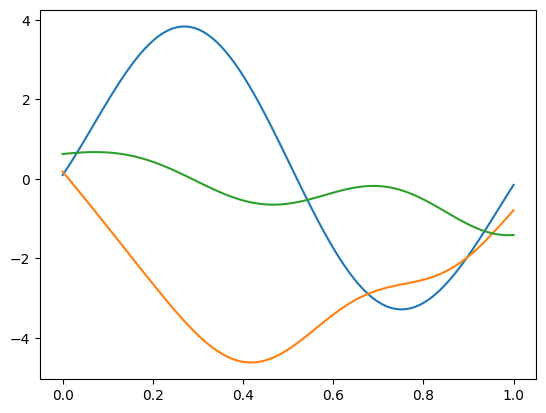

In [7]:
#plotting 3 of the random generated curves
plt.plot(x, U[:, :3])

In [8]:
def integrate_one_function(f):
  result = np.zeros_like(f)
  result[0]=0
  for i in range(1, len(f)):
    result[i] = integrate.simpson(y=f[:i+1], x=x[:i+1])
  return result

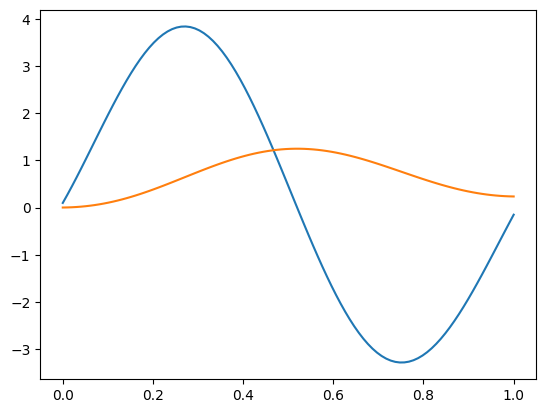

In [9]:
#plotting the integration result of the first curve
f = U[:, 0]
f_int = integrate_one_function(f)
plt.plot(x, f)
plt.plot(x, f_int)

In [12]:
#integrating all curves and storing at S
S = np.zeros((m,n))
for i in range(n):
  S[:,i] = integrate_one_function(U[:,i])

In [15]:
#shaping the array form
# US -> m*n = 11000 ==> US(11000, 100) eleven thousand data points
# with one hundred columns (input to train)
# XS -> (11000, 1) input we need to answer
# SS -> (11000, 1) output

def interate_data(m=m, n=n, x=x, U=U, S=S):
  US=np.zeros((m*n, m))
  XS=np.zeros((m*n, 1))
  SS=np.zeros((m*n, 1))
  for i in range(n):
    for j in range(m):
      US[i*m+j, :] = U[:,i]
      XS[i*m+j, :] = x[j]
      SS[i*m+j, :] = S[j,i]
  return US, XS, SS

In [16]:
US, XS, SS = interate_data()
print(US.shape, XS.shape, SS.shape)

(11000, 100) (11000, 1) (11000, 1)


In [17]:
def batch_dataset(batch_size, n=n, m=m, x=x, U=U, S=S, ratio=0.9):
  US, XS, SS = interate_data(m, n, x, U, S)
  #10% of datapoint to the train dataset
  train_size = int(len(US)*ratio)
  us_train = US[:train_size]
  xs_train = XS[:train_size]
  ss_train = SS[:train_size]

  us_test = US[train_size:]
  xs_test = XS[train_size:]
  ss_test = SS[train_size:]

  #converting the train arrays to tesors
  us_train = torch.tensor(us_train, dtype=torch.float32)
  xs_train = torch.tensor(xs_train, dtype=torch.float32)
  ss_train = torch.tensor(ss_train, dtype=torch.float32)
  #creating a TensorDataset for the train set
  train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
  #loading train data on train_dataset and shuffling them
  train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True)

  #converting the test arrays to tesors
  us_test = torch.tensor(us_test, dtype=torch.float32)
  xs_test = torch.tensor(xs_test, dtype=torch.float32)
  ss_test = torch.tensor(ss_test, dtype=torch.float32)
  # creating a TensorDataset for the test set
  test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
  #loading train data on test_dataset and shuffling them
  test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True)

  return train_dataloader, test_dataloader

In [18]:
#creating train and test data
train_data, test_data = batch_dataset(batch_size=32, ratio=0.9)

In [19]:
class DeepONet(nn.Module):
  def __init__(self, neurons = 40, in1=1, in2=1, output_neurons=20):
    super(DeepONet, self).__init__()
    self.in1 = in1
    self.in2 = in2
    self.output_neurons = output_neurons
    self.neurons = neurons

    self.branch = self.branch_network()
    self.trunk = self.trunk_network()

  #the branch network will recive all the data points
  def branch_network(self):
    branch = nn.Sequential(
        nn.Linear(self.in1, self.neurons),
        nn.ReLU(),
        #hidden layer
        nn.Linear(self.neurons, self.neurons),
        nn.ReLU(),
        nn.Linear(self.neurons, self.output_neurons)
        )
    return branch


  #the trunk network will recive the integration's location
  def trunk_network(self):
    trunk = nn.Sequential(
        nn.Linear(self.in2, self.neurons),
        nn.ReLU(),
        #hidden layer
        nn.Linear(self.neurons, self.neurons),
        nn.ReLU(),
        #hidden layer
        nn.Linear(self.neurons, self.neurons),
        nn.ReLU(),
        nn.Linear(self.neurons, self.output_neurons)
        )
    return trunk

  def forward(self, x1, x2):
    x1 = self.branch(x1)
    x2 = self.trunk(x2)
    x = torch.einsum('bi, bi->b', x1, x2)
    x = torch.unsqueeze(x, 1)
    return x

In [20]:
model = DeepONet(neurons=40, in1=m, in2=1)
model

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

In [21]:
def loss(y_pred, y):
  return torch.mean((y_pred-y)**2)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
train_losses = []

epochs=800
for i in range(epochs):
  l_total = 0
  for u_batch, x_batch, s_batch in train_data:
    model.train()
    optimizer.zero_grad()
    y_pred = model(u_batch, x_batch)

    l = loss(y_pred, s_batch)
    l_total += l.item()
    l.backward()
    optimizer.step()

  l_total = l_total/len(train_data)
  train_losses.append(l_total)

  if i%100 == 0:
    print(f'Epoch: {i}/{epochs} - Loss: {l_total}')

Epoch: 0/800 - Loss: 0.04249502694564721
Epoch: 100/800 - Loss: 0.0002109325096934035
Epoch: 200/800 - Loss: 0.00021870892032306837
Epoch: 300/800 - Loss: 8.392868800705577e-05
Epoch: 400/800 - Loss: 7.964599830771594e-05
Epoch: 500/800 - Loss: 0.00011426818363683959
Epoch: 600/800 - Loss: 6.854088076491485e-05
Epoch: 700/800 - Loss: 0.000138379409221553


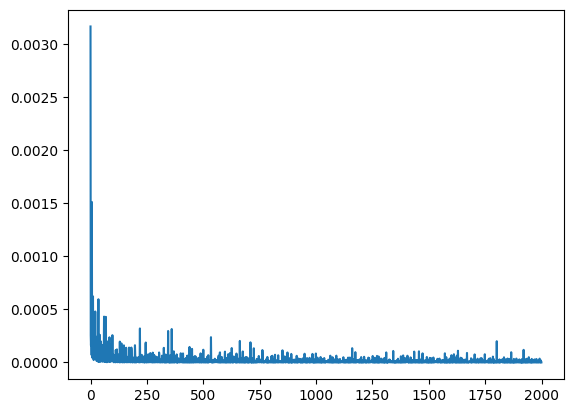

In [21]:
plt.plot(train_losses)

In [24]:
my_func = lambda x: np.cos(5*x)
inter = lambda x: 1/5*np.sin(5*x)
u_t = my_func(x)
s_t = inter(x)

In [25]:
model.eval()

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

In [26]:
u_t_tens = torch.tensor(u_t, dtype=torch.float32)
u_t_tens = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0)
x_tens = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

p = model(u_t_tens, x_tens)
p = p.detach().numpy()

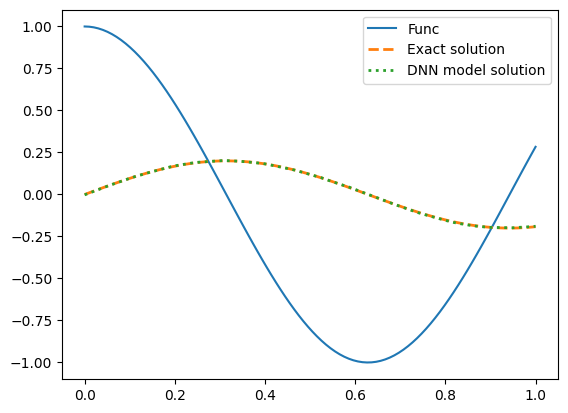

In [39]:
plt.plot(x, u_t, label='Func')
plt.plot(x, s_t, label='Exact solution', linestyle='--', linewidth=2)
plt.plot(x, p, label='DNN model solution', linestyle=':', linewidth=2)
plt.legend()